<a href="https://colab.research.google.com/github/insightcampus/202008-youth-bigdata/blob/master/%EB%84%A4%EC%9D%B4%EB%B2%84%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84_%EC%9C%84%ED%95%9C_%EC%A0%84%EC%B2%98%EB%A6%AC_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  텐서플로우를 실행 할 때, 항상 아래 코드를 입력해 주어야 합니다.
# tensorflow_version 2.0

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# 코랩설치
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
     |████████████████████████████████| 19.4MB 236kB/s 
     |████████████████████████████████| 92kB 8.6MB/s 
     |████████████████████████████████| 3.8MB 47.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6

In [5]:
from konlpy.tag import Mecab
m = Mecab()
m.nouns('메캡이 잘 실행 될까요?')

['메', '캡', '실행']

## 데이터 불러오기

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
import pandas as pd
import numpy as np
# read train_data and test_data
train_df = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/naver/ratings_train.txt', sep='\t', quoting=3))
train_df = train_df.replace(np.nan, '', regex=True)
test_df = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/naver/ratings_test.txt', sep='\t', quoting=3))
test_df = test_df.replace(np.nan, '', regex=True)
print('train :',len(train_df))
print('test :', len(test_df))

train : 150000
test : 50000


In [34]:
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 전처리와 토큰화

In [35]:
import re 
# '한글'을 제외한 다른 문자 모두 제거
remove_except_ko = re.compile(r"[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]")
def preprocess(text):
    text = re.sub(remove_except_ko,' ',text).strip()
    return text

train_df['document'] = train_df['document'].map(lambda x : preprocess(x))
test_df['document'] = test_df['document'].map(lambda x : preprocess(x))

In [36]:
train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [37]:
from konlpy.tag import Mecab
mecab = Mecab()
# mecab을 사용해서 토큰화, 한글자 제거, stop_word 제거 
stop_word = ['께서','에서','이다','에게','으로','이랑','까지','부터','하다']
def postagging_mecab(text):
    text = mecab.morphs(text)
    text = [i for i in text if len(i)>1]
    text = [i for i in text if i not in stop_word]
    return text

In [39]:
# 토큰화 + 토큰리스트 생성 
def make_tokens(df):
    df['tokens'] = ''
    tokens_list=[]
    for i, row in df.iterrows():
        if i%10000==0:
            print(i,'/',len(df))
        token = postagging_mecab(df['document'][i])
        tokens_list.append(token)
        df['tokens'][i] = token
    return tokens_list,df

#train_list,train_df = make_tokens(train_df)
test_list,test_df = make_tokens(test_df)


0 / 50000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000


In [40]:
train_list,train_df = make_tokens(train_df)

0 / 150000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


10000 / 150000
20000 / 150000
30000 / 150000
40000 / 150000
50000 / 150000
60000 / 150000
70000 / 150000
80000 / 150000
90000 / 150000
100000 / 150000
110000 / 150000
120000 / 150000
130000 / 150000
140000 / 150000


토큰화된 단어 벡터화
from tensorflow.keras.preprocessing.text import Tokenizer

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
# make train word set  
tokenizer.fit_on_texts(train_list)

In [42]:
#4만 6979개의 word set 
print(tokenizer.word_index)

{'영화': 1, '는데': 2, '너무': 3, '정말': 4, '네요': 5, '재밌': 6, '지만': 7, '진짜': 8, 'ㅋㅋ': 9, '연기': 10, '최고': 11, '평점': 12, '이런': 13, '어요': 14, '스토리': 15, '습니다': 16, 'ㅋㅋㅋ': 17, '아니': 18, '드라마': 19, '생각': 20, '사람': 21, '감동': 22, '배우': 23, '만들': 24, '내용': 25, '보다': 26, '감독': 27, '재미': 28, '그냥': 29, '시간': 30, '재미있': 31, '지루': 32, '재미없': 33, '쓰레기': 34, '사랑': 35, '라고': 36, '면서': 37, '다시': 38, '나오': 39, '하나': 40, '작품': 41, '이거': 42, '해서': 43, '마지막': 44, '이건': 45, '정도': 46, '액션': 47, '기대': 48, '입니다': 49, '완전': 50, '라는': 51, '다는': 52, '아깝': 53, '처음': 54, '장면': 55, '다가': 56, '으면': 57, '지금': 58, '모르': 59, '이렇게': 60, '이게': 61, '최악': 62, '느낌': 63, '이야기': 64, '별로': 65, '봐도': 66, '어서': 67, 'ㅠㅠ': 68, '인데': 69, '다고': 70, '이해': 71, '명작': 72, '그리고': 73, '역시': 74, '여자': 75, '이상': 76, '한국': 77, '는지': 78, '많이': 79, '주인공': 80, '합니다': 81, '우리': 82, '괜찮': 83, '만든': 84, '기억': 85, '한다': 86, 'ㅎㅎ': 87, '연출': 88, '때문': 89, '이나': 90, '현실': 91, 'ㅡㅡ': 92, '무슨': 93, '마음': 94, '내내': 95, '결말': 96, '전개': 97, '남자': 98, '세요': 99, '소재'

In [44]:
#단어를 숫자배열로 변환 
X_train_arrary_list = tokenizer.texts_to_sequences(train_list)
X_test_arrary_list = tokenizer.texts_to_sequences(test_list)
X_train = X_train_arrary_list
X_test = X_test_arrary_list
# 레이블링 데이터 행렬변환
Y_train = np.array(train_df['label'])
Y_test = np.array(test_df['label'])
print('훈련데이터 : ',len(X_train_arrary_list))

훈련데이터 :  150000


In [45]:
# 확인
print(train_list[:7])
print(X_train_arrary_list[:7])

[['진짜', '짜증', '네요', '목소리'], ['포스터', '보고', '초딩', '영화', '오버', '연기', '조차', '가볍', '구나'], ['너무', '밓었다그래서보는것을추천한다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '평점', '조정'], ['사이몬페그', '익살', '스런', '연기', '돋보였', '영화', '스파이더맨', '보이', '커스틴', '던스트', '너무나', '이뻐', '보였'], ['걸음마', '초등', '학교', '학년', '살용', '영화', 'ㅋㅋㅋ', '별반', '아까움'], ['원작', '긴장감', '제대로', '살려', '못했']]
[[8, 105, 5, 449], [294, 304, 411, 1, 1126, 10, 575, 636, 206], [3, 26782], [6971, 64, 3387, 142, 28, 12, 2638], [20051, 7396, 713, 10, 2102, 1, 2029, 177, 13945, 20052, 232, 2314, 1221], [20053, 1041, 430, 1167, 26783, 1, 17, 1614, 461], [121, 196, 200, 1422, 511]]


### 패딩

In [46]:
X_train

[[8, 105, 5, 449],
 [294, 304, 411, 1, 1126, 10, 575, 636, 206],
 [3, 26782],
 [6971, 64, 3387, 142, 28, 12, 2638],
 [20051, 7396, 713, 10, 2102, 1, 2029, 177, 13945, 20052, 232, 2314, 1221],
 [20053, 1041, 430, 1167, 26783, 1, 17, 1614, 461],
 [121, 196, 200, 1422, 511],
 [946,
  53,
  452,
  9180,
  13946,
  10,
  1023,
  118,
  4,
  178,
  391,
  311,
  2502,
  7397,
  980,
  980,
  19,
  146,
  10,
  21,
  26784],
 [47, 2, 28, 1],
 [12, 458, 291, 998, 447, 3, 13947],
 [26785, 8],
 [237, 1818, 1937, 558, 11030, 416, 2030, 1615, 5464],
 [37, 12274, 26786, 6575, 26787, 16353, 3030, 10, 833, 1233],
 [1837, 867, 43, 7912, 2002, 26, 547, 26788, 21, 52],
 [582, 3180, 13948, 8, 1354, 162, 1, 110, 22, 15, 803, 22, 2974],
 [1962, 909, 68],
 [21,
  769,
  6248,
  26789,
  16354,
  36,
  4169,
  947,
  1071,
  36,
  16355,
  29,
  67,
  6249,
  131,
  897],
 [4882, 11031, 825, 71, 2, 323, 33],
 [45, 4, 1900, 263, 16356, 5689, 25, 281, 16357, 1900],
 [16358, 325, 3765, 9986, 1132, 224, 26790],


리뷰의 최대 길이 : 65
리뷰의 평균 길이 : 7.4033


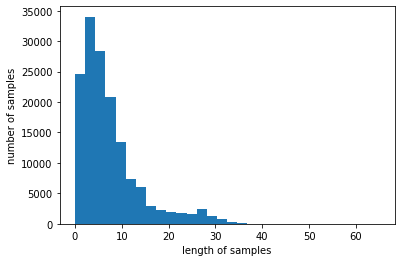

In [47]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [48]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.126


In [49]:
# 데이터 길이 30으로 패딩 
max_len = 30
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [50]:
len(X_train)

150000

In [51]:
X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  294,
        304,  411,    1, 1126,   10,  575,  636,  206], dtype=int32)

# LSTM을 사용한 감성분석

LSTM

In [52]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:
vocab_size = len(X_train)
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [54]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합이 될수 있기 때문에 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping). 
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./data/naver_movie_model_lstm', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [55]:
# generate model 
# loss = 'sparse_categorical_crossentropy' # 분류모델사용 
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.4261 - acc: 0.7962
Epoch 00001: val_acc improved from -inf to 0.81473, saving model to ./data/naver_movie_model_lstm
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./data/naver_movie_model_lstm/assets
2000/2000 [==============================] - 193s 96ms/step - loss: 0.4261 - acc: 0.7962 - val_loss: 0.3917 - val_acc: 0.8147
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.3697 - acc: 0.8310
Epoch 00002: val_acc improved from 0.81473 to 0.82097, saving model to ./data/naver_movie_model_lstm
INFO:tensorflow:Assets written to: ./data/naver_movie_model_lstm/assets
2000/2000 [==============================] - 198s 99ms/step - loss: 0.3697 - acc: 0.8310 - val_loss: 0.3810 - v

In [56]:
loaded_model = load_model('./data/naver_movie_model_lstm')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, Y_test)[1]))

1563/1563 [==============================] - 17s 11ms/step - loss: 0.3884 - acc: 0.8222

 테스트 정확도: 0.8222


In [57]:
def predict_pos_text(text):
    token=[]
    tokens = postagging_mecab(text) 
    token.append(tokens)
    print(token)
    X_train_arrary_list = tokenizer.texts_to_sequences(token)
    max_len=30
    X_train = pad_sequences(X_train_arrary_list, maxlen = max_len)
    score = float(loaded_model.predict(X_train))
    print('score:', type(score))
    if score>0.5:
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰입니다.\n".format(text, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰입니다.\n".format(text, (1 - score) * 100))

In [58]:
predict_pos_text('3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??')

[['아니', '어도', '다섯', '텐데', '나와서', '심기', '불편']]
score: <class 'float'>
[3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??]는 97.02% 확률로 부정 리뷰입니다.



In [59]:
predict_pos_text('영화 너무 재미있어요! 아이랑 잘 봤습니다')

[['영화', '너무', '재미있', '어요', '아이', '습니다']]
score: <class 'float'>
[영화 너무 재미있어요! 아이랑 잘 봤습니다]는 97.40% 확률로 긍정 리뷰입니다.



In [60]:
predict_pos_text('정말쓰레기영화입니다')

[['정말', '쓰레기', '영화', '입니다']]
score: <class 'float'>
[정말쓰레기영화입니다]는 98.90% 확률로 부정 리뷰입니다.



In [61]:
predict_pos_text('발연기 도저히 못보겠다 진짜 이렇게 연기를 못할거라곤 상상도 못했네')

[['발연기', '도저히', '진짜', '이렇게', '연기', '라곤', '상상', '못했']]
score: <class 'float'>
[발연기 도저히 못보겠다 진짜 이렇게 연기를 못할거라곤 상상도 못했네]는 99.12% 확률로 부정 리뷰입니다.



In [62]:
predict_pos_text('담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을')

[['담백', '깔끔', '해서', '신문', '기사', '보다', '자꾸', '잊어버린다', '사람', '다는']]
score: <class 'float'>
[담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을]는 91.79% 확률로 긍정 리뷰입니다.



In [63]:
predict_pos_text('이영화는 명작이다. 사회적 모순을 모두 담은 영화였다 조디 포스터는 더 마초적인 모습으로 과거의 아픔을 숨기며 성공에 이를 악물고 살며 닥터 랙터와 이야기를 나누며 서로는 약간의 동질감을 느꼈을 수도 있다.')

[['영화', '명작', '사회', '모순', '모두', '영화', '조디', '포스터', '마초', '모습', '과거', '아픔', '숨기', '성공', '악물', '닥터', '이야기', '나누', '서로', '약간', '동질감', '느꼈']]
score: <class 'float'>
[이영화는 명작이다. 사회적 모순을 모두 담은 영화였다 조디 포스터는 더 마초적인 모습으로 과거의 아픔을 숨기며 성공에 이를 악물고 살며 닥터 랙터와 이야기를 나누며 서로는 약간의 동질감을 느꼈을 수도 있다.]는 98.43% 확률로 긍정 리뷰입니다.



In [64]:
predict_pos_text('강력한 몰입감을 선사하는 두 배우의 연기력!! 오랜만에 정말 색다른 영화였다')

[['강력', '입감', '선사', '배우', '연기력', '오랜만', '정말', '색다른', '영화']]
score: <class 'float'>
[강력한 몰입감을 선사하는 두 배우의 연기력!! 오랜만에 정말 색다른 영화였다]는 99.17% 확률로 긍정 리뷰입니다.



In [65]:
predict_pos_text('정말 모르겠다 재미와 감동은 잘모르겠다')

[['정말', '모르', '재미', '감동', '모르']]
score: <class 'float'>
[정말 모르겠다 재미와 감동은 잘모르겠다]는 56.77% 확률로 긍정 리뷰입니다.

